In this project, I will be calculating flood return periods and exceedance probability using Python. I will also use streamflow data to explore the probabilities of different magnitude events.
I will use the hydrofunctions python package to access streamflow data via an API from the United States Geological Survey (USGS) National Water Information System (NWIS) website.

In [1]:
!pip3 install hydrofunctions

In [2]:
# importing the libraries
import os
import urllib
import requests
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import earthpy as et
import hydrofunctions as hf

# date time confersion registry
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(font_scale=1.5, style='whitegrid')

%matplotlib inline


In [3]:
hf.draw_map()

In [4]:
# downloading the data and defining parameters
site = "06730500"
start = '1946-05-10'
end = '2018-08-29'

# request data
longmont_resp = hf.get_nwis(site, 'dv', start, end)


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06730500&startDT=1946-05-10&endDT=2018-08-29


In [5]:
# convert the response to a json in order to use the extract.get_nwis() function
longmont_resp = longmont_resp.json()

# get metadata about the data
hf.get_nwis(site,'dv').json()

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06730500


{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/dv/format=json%2C1.1&sites=06730500',
   'criteria': {'locationParam': '[ALL:06730500]',
    'variableParam': 'ALL',
    'parameter': []},
   'note': [{'value': '[ALL:06730500]', 'title': 'filter:sites'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2023-01-06T02:23:16.305Z', 'title': 'requestDT'},
    {'value': '13e23df0-8d69-11ed-a9e6-005056beda50', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'caas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': 'BOULDER CREEK AT MOUTH

In [6]:
# requesting the data to return a pandas dataframe
longmont_dis = hf.extract_nwis_df(longmont_resp)
longmont_dis = longmont_dis[0]

c:\Users\Juliance\Desktop\Earth_DS\.venv\lib\site-packages\hydrofunctions\hydrofunctions.py:629: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not DF.index.is_monotonic:


In [7]:
# changing the column names
longmont_dis.columns = ['discharge','flag']
longmont_dis.head()

discharge flag
datetimeUTC                              
1946-05-10 00:00:00+00:00       16.0    A
1946-05-11 00:00:00+00:00       19.0    A
1946-05-12 00:00:00+00:00        9.0    A
1946-05-13 00:00:00+00:00        3.0    A
1946-05-14 00:00:00+00:00        7.8    A

In [8]:
!pip3 install pyqt5

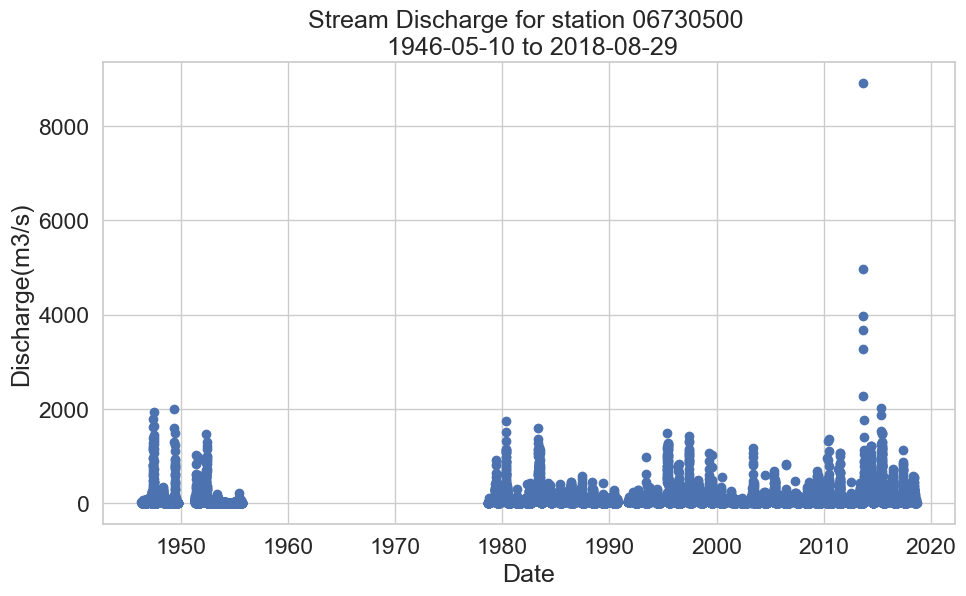

In [9]:
# plotting the data 
import PyQt5
f,ax = plt.subplots(figsize=(11,6))

ax.scatter(
    x=longmont_dis.index,
    y = longmont_dis['discharge']
)
ax.set(
    xlabel='Date',
    ylabel = 'Discharge(m3/s)',
    title= 'Stream Discharge for station {} \n {} to {}'.format(site,start,end)
)

plt.show()

Calculating the Annual Maxima of both the instantenous flow and the mean daily stream flow. This can be done in two ways.
- Taking the daily mean values to construct a series of annual maximum values.
- Downloading the instantenous annual maximum data. 

In [10]:
# creating the year column
longmont_dis['Year'] = longmont_dis.index.year

# resampling the dataset to get mean yearly maximum
longmont_annual_max = longmont_dis.resample('AS').max()
longmont_annual_max.head()

discharge        flag  Year
datetimeUTC                                           
1946-01-01 00:00:00+00:00       99.0           A  1946
1947-01-01 00:00:00+00:00     1930.0           A  1947
1948-01-01 00:00:00+00:00      339.0           A  1948
1949-01-01 00:00:00+00:00     2010.0  hf.missing  1949
1950-01-01 00:00:00+00:00        NaN  hf.missing  1950

In [11]:
# download usgs annual max data from figshare
url = "https://nwis.waterdata.usgs.gov/nwis/peak?site_no=06730500&agency_cd=USGS&format=rdb"
#download_path = os.path.join("Earth_DS", "colorado-flood", 
                             #"downloads", "annual-peak-flow.txt")

urllib.request.urlretrieve(url)

('C:\\Users\\Juliance\\AppData\\Local\\Temp\\tmp4wk2x9j1',
 <http.client.HTTPMessage at 0x129dc3c3df0>)

In [31]:
# a function that counts all lines that are commented
def count(file_url):
    r = requests.get(file_url, stream=True)
    file = r.text
    count = 0
    for line in file:
        if line.startswith('#'):
            count += 1
    return count


# lines to skip
lines_to_skip = count(url)+1

In [37]:
data = pd.read_csv(
    "C:/Users/Juliance/Desktop/Earth_DS/colorado-flood/downloads/tmp3gjo8xnm",
    skiprows = [lines_to_skip],
    comment= "#",
    sep='\t',
    usecols=['peak_dt','peak_va'],
    parse_dates=['peak_dt'],
    index_col='peak_dt'
)

# removing the first row
#data.drop(index='10d', inplace=True)
data.head()

peak_va
peak_dt            
1927-07-29    407.0
1928-06-04    694.0
1929-07-23    530.0
1930-08-18    353.0
1931-05-29    369.0

In [38]:
# adding a year column to the data
data['year'] = data.index.year

# drop duplicates - keep max discharge value
data = data.sort_values("peak_va", ascending=False).drop_duplicates("year").sort_index()


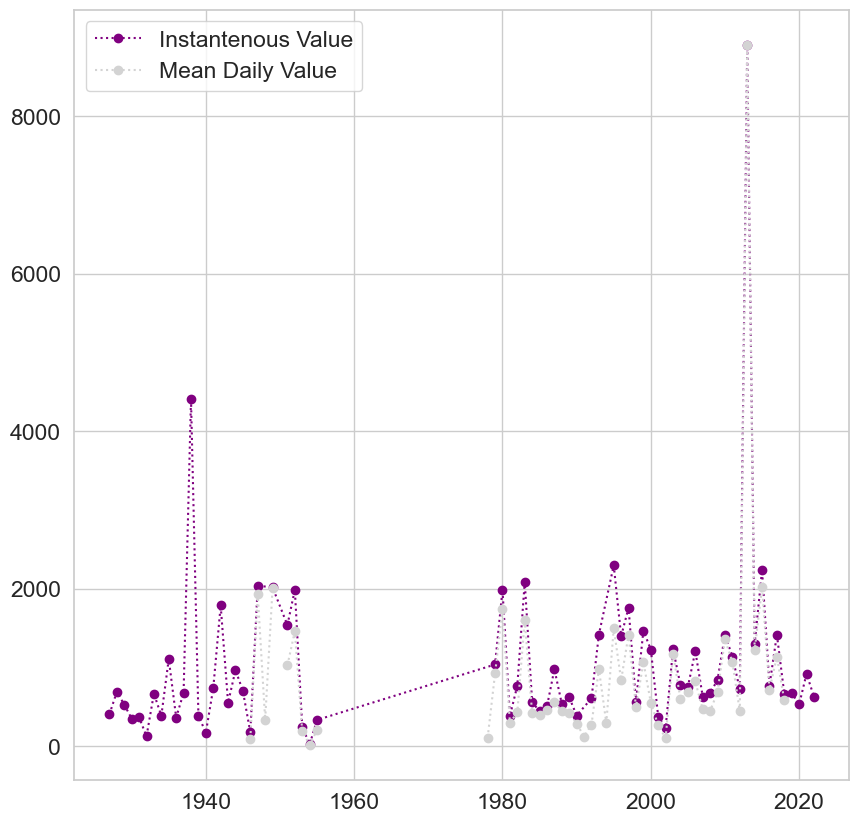

In [45]:
# plotting the two sets of data to see if there is any difference

fig,ax=plt.subplots(figsize=(10,10))

ax.plot(
    data['year'],
    data['peak_va'],
    color='purple',
    linestyle=':',
    marker='o',
    label='Instantenous Value'
)

ax.plot(
    longmont_annual_max['Year'],
    longmont_annual_max['discharge'],
    color='lightgrey',
    linestyle=':',
    marker='o',
    label='Mean Daily Value'
)
ax.legend()
plt.show()

In [47]:
# calculating the cumulative sum of the runoff discharge for the dataset
# converting the runoff area from square miles(447) to square kms
area = 2.58999 * 447

# convert cubic feet per second to cubic feet per day
cubic_feet_day = (60*60*24)
convert_to_runoff = cubic_feet_day * area
convert_to_runoff


100027485.792

In [50]:
# calculate the cumsum
longmont_dis['cum_sum'] = longmont_dis['discharge'].cumsum()*convert_to_runoff

longmont_dis.head()

discharge flag  Year       cum_sum
datetimeUTC                                                  
1946-05-10 00:00:00+00:00       16.0    A  1946  1.600440e+09
1946-05-11 00:00:00+00:00       19.0    A  1946  3.500962e+09
1946-05-12 00:00:00+00:00        9.0    A  1946  4.401209e+09
1946-05-13 00:00:00+00:00        3.0    A  1946  4.701292e+09
1946-05-14 00:00:00+00:00        7.8    A  1946  5.481506e+09

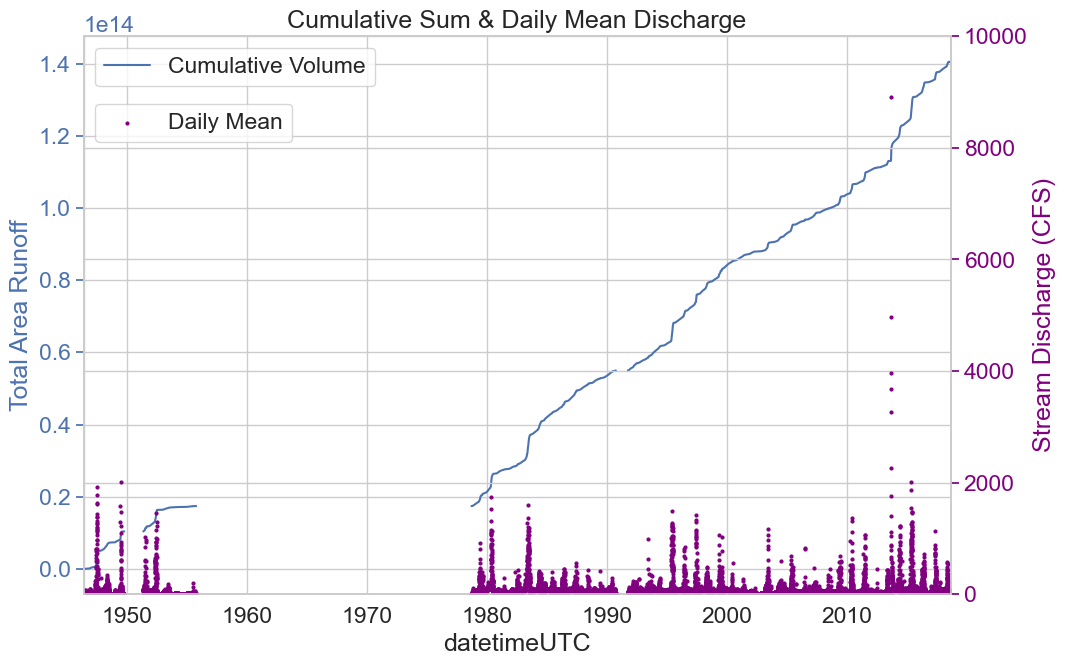

In [57]:
fig, ax = plt.subplots(figsize=(11,7))
longmont_dis["cum_sum"].plot(ax=ax, label = "Cumulative Volume")

# Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('Total Area Runoff', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()

ax2.scatter(x=longmont_dis.index, 
        y=longmont_dis["discharge"], 
        marker="o",
        s=4, 
        color ="purple", label="Daily Mean")

ax2.set_ylabel('Stream Discharge (CFS)', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_ylim(0,10000)

ax.set_title("Cumulative Sum & Daily Mean Discharge")
ax.legend()

# Reposition the second legend so it renders under the first legend item
ax2.legend(loc = "upper left", bbox_to_anchor=(0.0, 0.9))

fig.tight_layout()

plt.show()

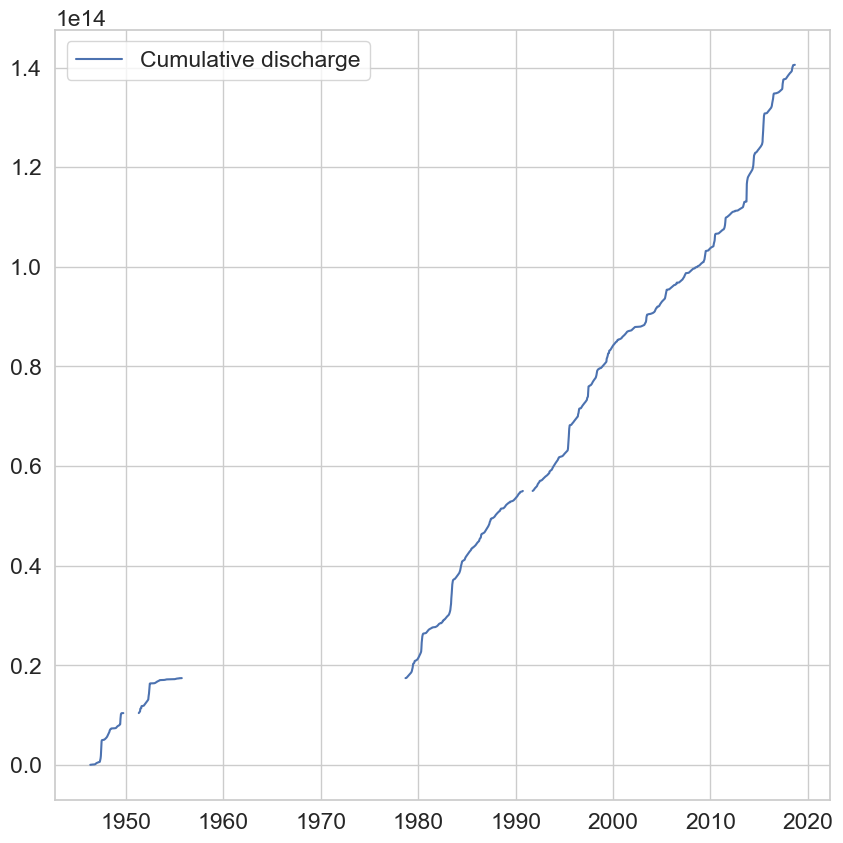

In [55]:
# plotting the daily discharge data and the cummulative discharge
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(
    x = longmont_dis.index,
    y= longmont_dis['discharge'],
    label='Daily Discharge'
)
ax.plot(
    longmont_dis.index,
    longmont_dis['cum_sum'],
    label='Cumulative discharge'
)
plt.legend()
plt.show()